In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#COLORS 
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
LIGHTBLUE = (255, 127, 0)
TURQUOISE = (255, 255, 0)
PINK = (255, 0, 255)
ORANGE = (0, 127, 255)
YELLOW = (0, 255, 255)

## Computer Vision

The purpose of this computer vision module is to provide the robot with information about the world globally surrounding it.

The computer vision module must be able to detect:
* The robot, it's position and orientation
* The obstacles
* The objectives
* The world scale

In order to detect these different objects, we decided to use different colors. And detect color ranges in the image. These colors will then be transformed to shapes. That allows us to extract the contours of obstacles or then centroids of targets. it will also allow us to find the orientation of the robot.



### Color detection

The idea behind our color detection is to define each of our interesting colors as a range of values. When using opneCV's default BGR color space, our colors would need to be defined as a volume in the color space. This is necessary because there are always variations in the color seen by the camera. Find and tunes these volumes in the BGR color space is difficult because BGR is not an intuitive way of describing colors. 
We decided to use the HSV color space because it is a more "human intuitive" representation of the colors.


#### The HSV color space
The HSV color space represents the colors in three dimensions like BGR. But it has a more human intuitive approach as the question of "which color it is?" (Hue) can be answered on one dimention. The two others are "the ammount of coloration" (Saturation and the "darkness" (Value). The HSV color space is a cylindrical coordinates representation of the colors as it is illustrated here:

<img src="images/hsv_cyl.png" alt="The HSV color space" width="600"/>

In OpenCV, we can easily convert an image to HSV using the color conversion function ```frame = cv2.cvtColor(imag, cv2.COLOR_BGR2HSV)```. The result will be an image with pixels encoded with three values: Hue (between 0 and 179), Saturation and Value (both between 0 and 255).
Thanks to this representation we can easily select colors by taking just a "slice of cylinder" defined by ```color_low = np.array([h_low, s_low, v_low], dtype=np.uint8)``` and ```color_high = np.array([h_high, s_high, v_high], dtype=np.uint8)```. Such a simple selection volume allows us to use the color selection function ```hsv = cv2.inRange(frame,  color_low, color_high)```. This function will return a mask that is white whenever a pixel is in the range of colors.

One of the problems with the HSV color range detection method is that the color is at the 179 -> 0 boundary. so wee need to choose between the yellowish red which is on the 0 side or the pinkish red which is on the 179 part. We decided not to handle the detection for all hues of red as it would add complexity and we can simply use another color :)


#### Range finding script
We wrote a simple range finding script to help us find the color boundaries for different interesting colors.
The script simply displays the webcam image with the inRange color mask as overlay. The range can be tuned in real time using sliders. This script allows us to tune the color detection for optimal performance in different ligntning environement and for different colors.





In [2]:
cap = cv2.VideoCapture(0)
     

cv2.namedWindow("Hsv detect", cv2.WINDOW_NORMAL)

cv2.createTrackbar('H low', 'Hsv detect', 0, 179, lambda empty: empty)
cv2.createTrackbar('S low', 'Hsv detect', 0, 255, lambda empty: empty)
cv2.createTrackbar('V low', 'Hsv detect', 0, 255, lambda empty: empty)

cv2.createTrackbar('H high', 'Hsv detect', 0, 179, lambda empty: empty)
cv2.createTrackbar('S high', 'Hsv detect', 0, 255, lambda empty: empty)
cv2.createTrackbar('V high', 'Hsv detect', 0, 255, lambda empty: empty)

cv2.setTrackbarPos('H low', 'Hsv detect', 83)
cv2.setTrackbarPos('S low', 'Hsv detect', 165)
cv2.setTrackbarPos('V low', 'Hsv detect', 100)

cv2.setTrackbarPos('H high', 'Hsv detect', 120)
cv2.setTrackbarPos('S high', 'Hsv detect', 255)
cv2.setTrackbarPos('V high', 'Hsv detect', 255)

while(True):

    ret, imag = cap.read()
    
    frame = cv2.cvtColor(imag, cv2.COLOR_BGR2HSV)
    
    

    # Trackbars realtime position
    h1 = cv2.getTrackbarPos('H low', 'Hsv detect')
    s1 = cv2.getTrackbarPos('S low', 'Hsv detect')
    v1 = cv2.getTrackbarPos('V low', 'Hsv detect')

    h2 = cv2.getTrackbarPos('H high', 'Hsv detect')
    s2 = cv2.getTrackbarPos('S high', 'Hsv detect')
    v2 = cv2.getTrackbarPos('V high', 'Hsv detect')

    color_low = np.array([h1, s1, v1], np.uint8)
    color_high = np.array([h2, s2, v2], np.uint8)

            
    hsv = cv2.inRange(frame,  color_low, color_high)
    
    hsv_inv = cv2.bitwise_not(hsv)
    
    blue = np.zeros(frame.shape, np.uint8)

    blue[:]=BLUE
    
    bg = cv2.bitwise_and(imag,imag,mask = hsv_inv)
    fg = cv2.bitwise_and(blue,blue,mask = hsv)
    
    final = cv2.bitwise_or(bg, fg)
   
    cv2.imshow('Hsv detect', final)
    
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Polygon extraction
Provided a mask of the colored areas, we need to the borders of the colored areas and transform those borders into simple polygons. 

This is done using OpenCV's findContours function ```contours, hierarchy = cv2.findContours(hsv, cv2.RETR_EXTERNAL  , cv2.CHAIN_APPROX_SIMPLE)``` The function uses an extended version of the border following algorithm. We configure the function so that it only returns external borders, thus eliminating holes in the mask and an approximation of the borders using as few points as possible. This is done in the function ```def find_color(frame, hsv_low, hsv_high)```

Then, we discard the borders that are too small as they are likely to be falsely identified objects. The following condition ```if (cv2.contourArea(cnt) >= AREA_THRESH):``` allows us to keep only the borders big enough.
The last step, is to merge the points that are too close together in order to create a low polygon approximation for each object. This is done in the function ```def cleanup_contours(contours, mode=0)```. 

#### Test script
In order to test the polygon extraction, we use the previously created sript with the polygon detection as addition. 


In [4]:
def cleanup_contours(contours, mode=0):
    #clean contours
    AREA_THRESH = 100
    MERGE_THRESH = 0.04
    EPSILON = 40
    
    clean_contours = []
    
    for cnt in contours:
        # only take big enough contours
        if (cv2.contourArea(cnt) >= AREA_THRESH):
            #convex hull
            #hull = cv2.convexHull(cnt)
            hull = cnt
            #lower poly approx
            if mode == 0:
                epsilon = MERGE_THRESH*cv2.arcLength(hull,True)
            else:
                epsilon = EPSILON
            approx = cv2.approxPolyDP(hull,epsilon,True)
            
            clean_contours.append(approx)
            
    return clean_contours


def find_color(frame, hsv_low, hsv_high):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    

    #Using inRange to find the desired range
    mask = cv2.inRange(hsv,  hsv_low, hsv_high)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL  , cv2.CHAIN_APPROX_SIMPLE)
    
    
    return cleanup_contours(contours)

In [5]:
cap = cv2.VideoCapture(0)
     

cv2.namedWindow("Hsv detect", cv2.WINDOW_NORMAL)

cv2.createTrackbar('H low', 'Hsv detect', 0, 179, lambda empty: empty)
cv2.createTrackbar('S low', 'Hsv detect', 0, 255, lambda empty: empty)
cv2.createTrackbar('V low', 'Hsv detect', 0, 255, lambda empty: empty)

cv2.createTrackbar('H high', 'Hsv detect', 0, 179, lambda empty: empty)
cv2.createTrackbar('S high', 'Hsv detect', 0, 255, lambda empty: empty)
cv2.createTrackbar('V high', 'Hsv detect', 0, 255, lambda empty: empty)

cv2.setTrackbarPos('H low', 'Hsv detect', 83)
cv2.setTrackbarPos('S low', 'Hsv detect', 165)
cv2.setTrackbarPos('V low', 'Hsv detect', 100)

cv2.setTrackbarPos('H high', 'Hsv detect', 120)
cv2.setTrackbarPos('S high', 'Hsv detect', 255)
cv2.setTrackbarPos('V high', 'Hsv detect', 255)

while(True):

    ret, frame = cap.read()
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    

    # Trackbars realtime position
    h1 = cv2.getTrackbarPos('H low', 'Hsv detect')
    s1 = cv2.getTrackbarPos('S low', 'Hsv detect')
    v1 = cv2.getTrackbarPos('V low', 'Hsv detect')

    h2 = cv2.getTrackbarPos('H high', 'Hsv detect')
    s2 = cv2.getTrackbarPos('S high', 'Hsv detect')
    v2 = cv2.getTrackbarPos('V high', 'Hsv detect')

    color_low = np.array([h1, s1, v1], np.uint8)
    color_high = np.array([h2, s2, v2], np.uint8)

            
    clean_contours = find_color(frame, color_low, color_high)
    
    cv2.drawContours(frame, clean_contours, -1, GREEN, 3)
    
    #draw points
    for cnt in clean_contours:
        for pt in cnt:
            frame = cv2.circle(frame, (pt[0][0], pt[0][1]), radius=5, color=RED, thickness=-1)
            
    cv2.imshow('Hsv detect', frame)
    
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Robot detection
In order to simply find the robot's position, we place a blue isosceles triangle on top the the Thymio. The triangle must be facing forward and it's long side must be twice as long as it's short side. 

#### Find the robot

![image](images/MR_01.png)

The idea for the robot detection is to find every polygon that is a triangle and sort them according to a score, The more the triangle has the right proportions, the lower score it gets. We then use the lowest score as the robot. 


$$Score = \frac{||dAB-dCA||^2 + 2\cdot{}||(dBC - dAB)||^2 + 2\cdot{}||(dBC - dCA)||^2}{||dAB||^2}$$

The score is calculated in python using the norm functions of numpy. ```score = (abs(dAB-dCA)+abs(K*dBC - dAB)+abs(K*dBC - dCA))/np.linalg.norm(dAB)```

#### Position, orientation and scale
From the triangle's summits, we can find the robot's position, orientation and size. The position and orientation will be used for control and the size is used during the initialisation to find the image's scale. The position of the robot is computed as the mean value of the triangle's vertices. 
The angle is computed from the triangle direction vector using numpy's ```angle = np.arctan2(direction[1], direction[0])``` function. This function calculates the angle of a vector with the arctangeant of it's components while properly handling the singularity at an angle of $\pi$. 

#### The code
The code takes an openCv standart frame as parameter as well as the scale of the world. It returns 

Robot position object: [position, angle, visible, size in px]
Robot position object: [array([1450,  892]), -1.6814535479687922, True, 104.13692908858029]


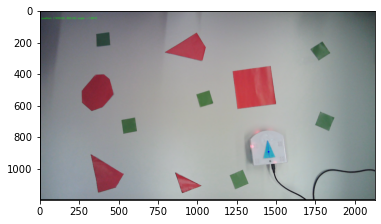

In [7]:
#calibration
BLUE_LOW  = [87, 129, 80]
BLUE_HIGH = [131, 255, 255]

def detect_robot(frame, scale=1):
    blue_low = np.array(BLUE_LOW, np.uint8)
    blue_high = np.array(BLUE_HIGH, np.uint8)
    frame = frame.copy()
    
    clean_contours = find_color(frame, blue_low, blue_high)
    
    good_cnt = []
    
    for cnt in clean_contours:
        if(len(cnt) == 3):
            K = 2
            A = 0
            B = 0
            C = 0
            dAB = 0
            dBC = 0
            dCA = 0
            p1 = cnt[0][0]
            p2 = cnt[1][0]
            p3 = cnt[2][0]
            d1 = np.linalg.norm(p2-p1)
            d2 = np.linalg.norm(p3-p2)
            d3 = np.linalg.norm(p1-p3)
            min_ix = np.argmin([d1, d2, d3])
            if(min_ix == 0):
                A = p3
                B = p2
                C = p1
                dAB = d2
                dBC = d1
                dCA = d3
            elif(min_ix == 1):
                A = p1
                B = p3
                C = p2
                dAB = d3
                dBC = d2
                dCA = d1
            else:
                A = p2
                B = p3
                C = p1
                dAB = d2
                dBC = d3
                dCA = d1
            score = abs(dAB-dCA)+abs(K*dBC - dAB)+abs(K*dBC - dCA)/np.linalg.norm(dAB)
            good_cnt.append([A, B, C, score])
                       
    good_cnt = sorted(good_cnt, key = lambda x: x[3])
    
    robot_pos = [np.array([0, 0]), 0, False, 0]
    
    if(len(good_cnt) > 0):
        robot_visible = True
        A = good_cnt[0][0]
        B = good_cnt[0][1]
        C = good_cnt[0][2]
        D = (np.mean([[B, C]], axis=1))[0]
        
        
        Center = (np.mean([[A, B, C]], axis=1))[0]

        direction = A - D
        
        size = np.linalg.norm(direction)
        
        angle = np.arctan2(direction[1], direction[0])
        
        frame = cv2.line(frame, (int(D[0]), int(D[1])), (int(A[0]), int(A[1])), color=BLUE, thickness=1)
        frame = cv2.circle(frame, (int(Center[0]), int(Center[1])), radius=5, color=BLUE, thickness=-1)
        Center = np.multiply(Center, scale).astype(int)
        text =  "position: ({:0.2f}, {:0.2f}) angle: {:0.4f}".format(Center[0], Center[1], angle)
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(frame, text, (10, 50), font, 0.5, GREEN, 1, cv2.LINE_AA)
        
        
        robot_pos = [Center, angle, True, size]
        
    return robot_pos, frame

frame = cv2.imread("images/colors.png")

pos, image = detect_robot(frame)


print("Robot position object: [position, angle, visible, size in px]")
print("Robot position object:", pos)
    
plt.imshow(image[:,:,::-1])


### Obstacles detection
The obstacles detection uses the polygon detection algorithm with the addition of the obstacles dilataion.

#### Dilatation
The idea for the second dilatation method is to move the edges of each polygon outwards of a certain ammount to guarantee that the robot does not touch an edge. Additionally, we elongate the moved edges in order to cover part of the corners. Then, we move each vertex outwards to fully conver the corners. All these new verices maake the dilated obstacle.

#### Overlapping obstacles merge
In some cases, after the dilatation, some obstacles that where aalready close might overlap. These overlapping obstacles should be merged into one. 

In order to do that, we draw the dilated polygons in white onto a black image. Then we run the contour finding alogorithm and openCV will find the merged dilated obstacles.



Contour object:  [array([[ 769,  934],
       [ 814, 1197],
       [1064, 1197],
       [1147, 1125],
       [1117, 1043],
       [ 852,  910]]), array([[ 249,  805],
       [ 278, 1197],
       [ 549, 1197],
       [ 659, 1021]]), array([[448, 279],
       [136, 490],
       [280, 752],
       [592, 545]]), array([[ 691,  209],
       [ 717,  347],
       [1058,  423],
       [1118,  350],
       [1173,  720],
       [1600,  665],
       [1540,  247],
       [1135,  296],
       [1180,  222],
       [1041,   19]])]


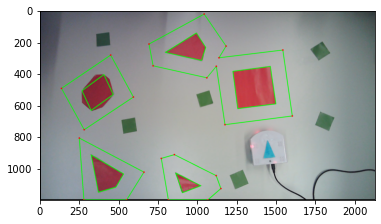

In [8]:
RED_LOW  = [150, 100, 100]
RED_HIGH = [179, 255, 255]

DIL_COEFF = 100
EXP_RATIO = 60

def detect_obstacles_alt(frame, scale=1):
    frame = frame.copy()
    red_low = np.array(RED_LOW, np.uint8)
    red_high = np.array(RED_HIGH, np.uint8)
    
    clean_contours = find_color(frame, red_low, red_high)
            
    original_contours = []
    dil_contour = []
    for cnt in clean_contours:
        mom = cv2.moments(cnt)
        if mom["m00"] != 0:
            cx = int(mom["m10"] / mom["m00"])
            cy = int(mom["m01"] / mom["m00"])
            C = np.array([cx, cy])
        else:
            C = np.array([0, 0])
        ncnt = []
        ocnt = []
        cnt = list(cnt)
        cnt.append(cnt[0])
        #print(cnt)
        for i, _ in enumerate(cnt[0:-1]):
            pt1 = cnt[i][0]
            pt2 = cnt[i+1][0]
            seg = pt2-pt1
            d = seg/np.linalg.norm(seg)
            n = np.array([-seg[1], seg[0]])/np.linalg.norm(seg)

            N = pt1-C
            N = N/np.linalg.norm(N)
            npt = (pt1+(DIL_COEFF+EXP_RATIO/2)/scale*N).astype(int)

            npt1 = (pt1+DIL_COEFF/scale*n - EXP_RATIO/scale*d).astype(int)
            npt2 = (pt2+DIL_COEFF/scale*n + EXP_RATIO/scale*d).astype(int)

            #frame = cv2.circle(frame, (npt[0], npt[1]), radius=5, color=(127, 0, 255), thickness=-1)
            #frame = cv2.circle(frame, (npt1[0], npt1[1]), radius=5, color=(0, 0, 255), thickness=-1)
            #frame = cv2.circle(frame, (npt2[0], npt2[1]), radius=5, color=(0, 127, 255), thickness=-1)

            ncnt.append(npt)
            ncnt.append(npt1)
            ncnt.append(npt2)
            ocnt.append(cnt[i][0])
        
        dil_contour.append(np.array(ncnt))
        original_contours.append(np.multiply(ocnt, scale).astype(int))
        
        
    
    cv2.drawContours(frame, clean_contours, -1, (0,255,0), 3)
    
    
    black = np.zeros(frame.shape[:2], dtype=np.uint8)
    
    for i in range(len(dil_contour)):
        cv2.drawContours(black, dil_contour, i, (255), -1)

    plt.imshow(frame)
    
    #find contours
    
    contours, hierarchy = cv2.findContours(black, cv2.RETR_EXTERNAL  , cv2.CHAIN_APPROX_SIMPLE)
    
    clean_dil_contours = cleanup_contours(contours, 1)
    cv2.drawContours(frame, clean_dil_contours, -1, (0,255,0), 3)

    scaled_contours = []
    for cnt in clean_dil_contours:
        ncnt = []
        for pt in cnt:
            frame = cv2.circle(frame, (pt[0][0], pt[0][1]), radius=5, color=(0, 0, 255), thickness=-1)
            ncnt.append(pt[0])
        scaled_contours.append(np.multiply(ncnt, scale).astype(int))
    
    
    return scaled_contours, original_contours, frame

frame = cv2.imread("images/colors.png")

cont, ret, image = detect_obstacles_alt(frame)

print("Contour object: ", cont)
    
plt.imshow(image[:,:,::-1])


### Target detection
The target detection uses the polygon detection and finds the centroid of each polygon 

code in py file.

targets object:  [[1263, 1067], [563, 726], [1807, 701], [1045, 555], [1778, 248], [401, 179]]


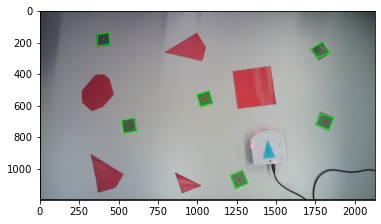

In [9]:
GREEN_LOW  = [41, 64, 0]
GREEN_HIGH = [85, 140, 140]
def detect_targets(frame, scale=1):
    frame = frame.copy()
    green_low = np.array(GREEN_LOW, np.uint8)
    green_high = np.array(GREEN_HIGH, np.uint8)
    
    clean_contours = find_color(frame, green_low, green_high)
    
    centroids = []
    
    for cnt in clean_contours:
        mom = cv2.moments(cnt)
        if mom["m00"] != 0:
            cx = int(mom["m10"] / mom["m00"])
            cy = int(mom["m01"] / mom["m00"])
            centroids.append([cx, cy])
        else:
            pass
            
        
            
    cv2.drawContours(frame, clean_contours, -1, (0,255,0), 3)
    scaled_centroids = []
    
    for pt in centroids:
        frame = cv2.circle(frame, (pt[0], pt[1]), radius=5, color=(0, 0, 255), thickness=-1)
        scaled_centroids.append(np.multiply(pt, scale).astype(int).tolist())
        
    return scaled_centroids, frame

frame = cv2.imread("images/colors.png")

targ, image = detect_targets(frame)
    
print("targets object: ", targ)
plt.imshow(image[:,:,::-1])

### Code encapsulation
To provide a clean interface for the other modules of the project, the code has been rearranged in a class. This allows us to handle internal global variables in a clean way.

In [ ]:
Class